In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from sklearn.neighbors import KNeighborsRegressor

import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

pd.set_option('display.max_rows', 100)

In [13]:
house_data = pd.read_csv("../data/Housing_data/housing-classification-iter7.csv", index_col="Id")

In [14]:
corr = house_data.corr()
corr_values = corr.unstack()
corr_values = corr_values.loc[corr_values!=1] # These features correlate with themselves
corr_values[corr_values > 0.8].sort_values(ascending=False)

GarageCars    GarageArea      0.882475
GarageArea    GarageCars      0.882475
YearBuilt     GarageYrBlt     0.825667
GarageYrBlt   YearBuilt       0.825667
GrLivArea     TotRmsAbvGrd    0.825489
TotRmsAbvGrd  GrLivArea       0.825489
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      TotalBsmtSF     0.819530
dtype: float64

In [15]:
def drop_correlated_features(df, correlation_threshold=0.8):
    # Create correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find index of feature columns with correlation greater than 0.95
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    print('features to drop: ', to_drop)

    # Drop features 
    return df.drop(df[to_drop], axis=1)

from sklearn.preprocessing import FunctionTransformer


data = house_data.copy()
print('# columns: ', len(data.columns))

correlation_transformer = FunctionTransformer(drop_correlated_features)
house_data = correlation_transformer.transform(data)
print('# columns: ', len(house_data.columns))

# columns:  80
features to drop:  ['1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea']
# columns:  76


In [16]:
def plot_predictions(y_true, y_pred): 
    print(
        f"""
        RMSLE: {mean_squared_log_error(y_true, y_pred)**0.5}
        MSE: {mean_squared_error(y_true, y_pred)}
        RMSE: {mean_squared_error(y_true, y_pred)**0.5}
        MAE: {mean_absolute_error(y_true, y_pred)}
        """
    )
    max_preds = min([max(y_pred.tolist()), max(y_true.tolist())])
    min_preds = max([min(y_pred.tolist()), min(y_true.tolist())])
    print(max_preds, min_preds)
    # plot
    plt.figure(figsize=(8,8))
    sns.scatterplot(x=y_pred, y=y_true)
    sns.lineplot(x=[min_preds,max_preds], y=[min_preds, max_preds], color='red')
    plt.ylabel('Observed')
    plt.xlabel('Predicted')
    plt.show()

    errors = y_pred - y_true
    plt.subplots(figsize=(12, 8))
    sns.histplot(errors)
    plt.vlines(x=0, ymin=0, ymax=150, color='red')
    plt.show()

    p_df = (
        pd.DataFrame({'y_true':y_true, 'y_pred':y_pred})
        .assign(error = lambda x: x['y_pred'] - x['y_true'])
        .sort_values(by='y_true')
        )

    plt.subplots(figsize=(12, 8))
    sns.scatterplot(data=p_df, x='y_true', y='error')
    plt.hlines(y=0, xmin=0, xmax=max(p_df['y_true']), color='red')
    plt.show()

In [80]:
X = house_data.drop(columns=['SalePrice'])
y = house_data['SalePrice']

# categoric_features = list(X.select_dtypes(include=["object"]))
# numeric_features = list(X.select_dtypes(exclude=["object"]))

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.8, random_state=8)#, stratify=categoric_features)

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

X_train.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
885,20,RL,65.0,7150,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,GdWo,NaN,0,7,2009,WD,Normal
642,60,FV,NaN,7050,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
1358,20,RL,NaN,12537,Pave,NaN,IR1,Lvl,AllPub,CulDSac,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
470,60,RL,76.0,9291,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,6,2008,WD,Normal
223,60,RL,85.0,11475,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,2,2006,WD,Normal


### Data encoding and normalization pipeline

In [25]:
# Encode the different feature types & impute missing values
numerical_features = ["OverallQual", "OverallCond", 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
                      'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
                      'BsmtUnfSF', 'TotalBsmtSF', '2ndFlrSF', 'LowQualFinSF', #  '1stFlrSF', 'TotRmsAbvGrd', 'GarageYrBlt', 'GarageArea',
                      'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
                      'BedroomAbvGr', 'KitchenAbvGr', 'Fireplaces',
                      'GarageCars', 'WoodDeckSF', 'OpenPorchSF',
                      'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
                      'MoSold', 'YrSold']

# Unordered categorical columns
nominative_categorical_features = ["MSZoning", "Street", "Alley", "LandContour", "LotConfig", "Neighborhood", "Condition1", 
                                   "Condition2", "BldgType", "HouseStyle", "RoofStyle", "RoofMatl",  "Exterior1st", "Exterior2nd", "MasVnrType", 
                                   "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", "SaleType", "SaleCondition"]

# Ordered categorical columns
ordinal_categorical_features  = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "HeatingQC", "KitchenQual", 
                                 "FireplaceQu", "GarageQual", "GarageCond", "PoolQC","LotShape", "LandSlope",
                                 "BsmtExposure", "BsmtFinType1", "BsmtFinType2", "Functional", "GarageFinish", 
                                 "PavedDrive", "Utilities", "CentralAir", "Electrical", "Fence"] 
ordinal_categories = [
    ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    ["None", "Po", "Fa", "TA", "Gd", "Ex"],
    ["None", "Reg", "IR1", "IR2", "IR3"],
    ["None", "Sev", "Mod", "Gtl"],
    ["None", "No", "Mn", "Av", "Gd"],
    ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["None", "Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    ["None", "Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    ["None", "Unf", "RFn", "Fin"],
    ["None", "N", "P", "Y"],
    ["None", "NoSeWa", "NoSewr", "AllPub"],
    ["None", "N", "Y"],
    ["None", "Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    ["None", "MnWw", "GdWo", "MnPrv", "GdPrv"]
]

# Create the scaling pipelines for categorical and numerical data
numeric_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),
    ('scale', MinMaxScaler())
])
one_hot_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy="constant", fill_value="None")),
    ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    #('one-hot', OneHotEncoder(drop='first', sparse=False))  # Causes an error on the test set because there are unknown 'None' values. Why?
])
ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy="constant", fill_value="None")),
    ('ordinal', OrdinalEncoder(categories=ordinal_categories)),
    ('scale', MinMaxScaler())
])

# Apply the scaling pipeline to both categorical and numerical columns
full_processor = ColumnTransformer(transformers=[
    ('numerical', numeric_pipeline, numerical_features), 
    ('one_hot', one_hot_pipeline, nominative_categorical_features), 
    ('ordinal', ordinal_pipeline, ordinal_categorical_features)
])

### Linear regression pipeline

r2 score:  0.7092206753823637

        RMSLE: 0.09681884026653147
        MSE: 292814637.56231904
        RMSE: 17111.82741738354
        MAE: 11649.885367773699
        
755000 41675.3370397104


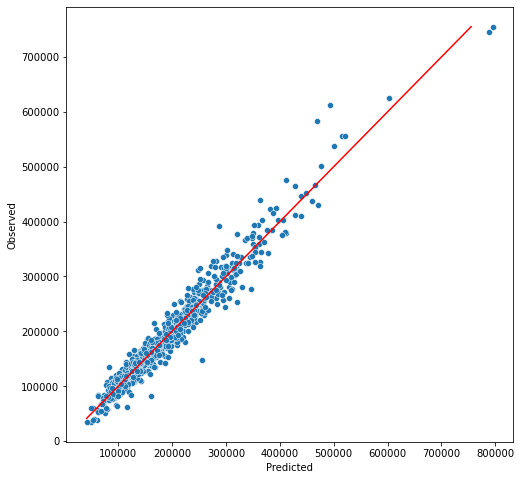

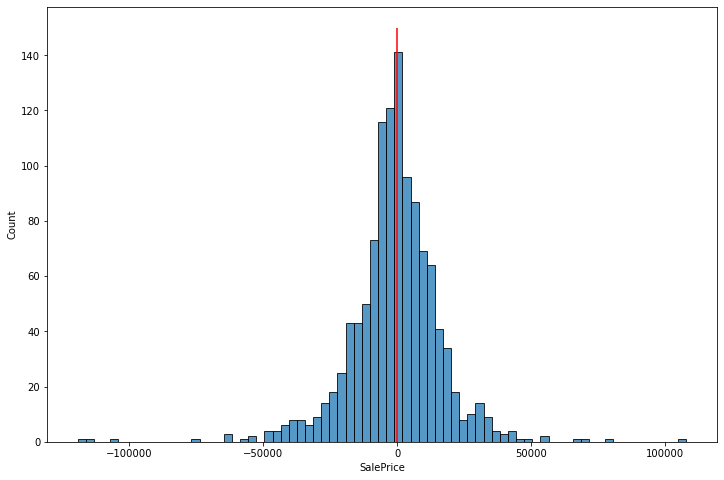

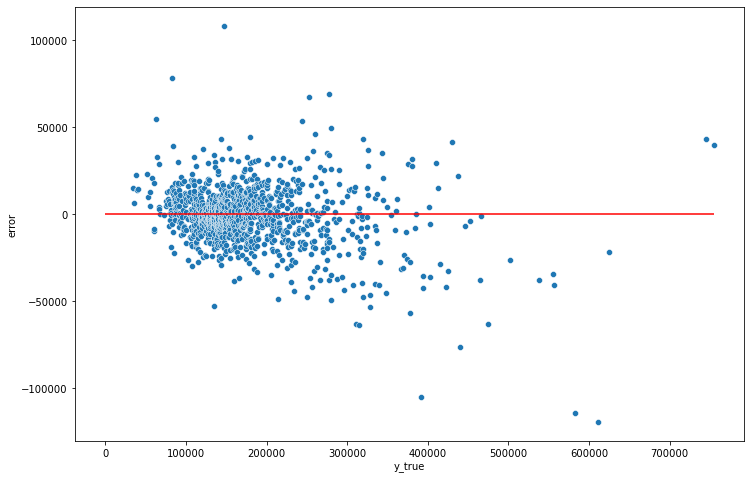

In [58]:
# Scale the ordinal data after encoding, fit the logarithm of the prices, impute numerical values with the median
lm_pipeline = Pipeline(steps=[
    ('processor', full_processor), 
    ('model', LinearRegression())
])

trained_lr_pipeline = lm_pipeline.fit(X_train, np.log(y_train))

# Plot the training data predictions
training_predictions = np.exp(trained_lr_pipeline.predict(X_train))
r2 = r2_score(y_test, y_pred)
print('r2 score: ', r2)
plot_predictions(y_train, training_predictions)

### Apply linear regression pipeline to test data

r2 score:  0.5376378154555126

        RMSLE: 0.711885274675047
        MSE: 2433067515.7180486
        RMSE: 49326.134206098584
        MAE: 16586.92369744431
        
485000 55000


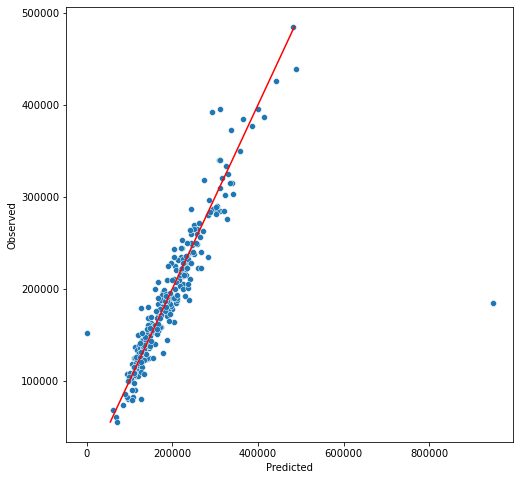

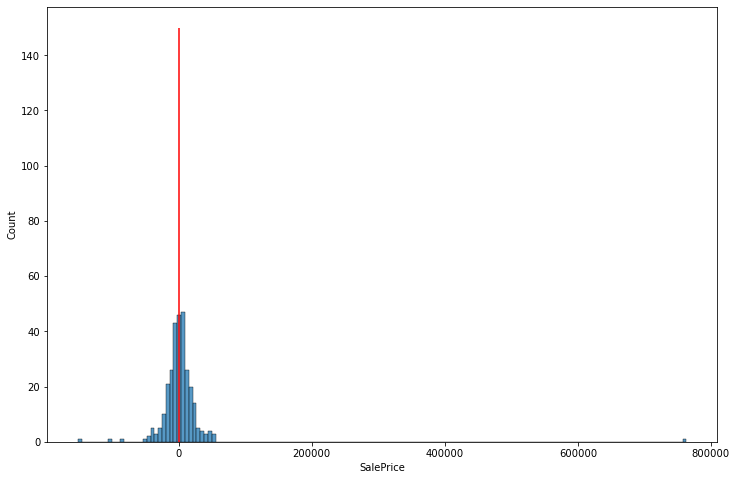

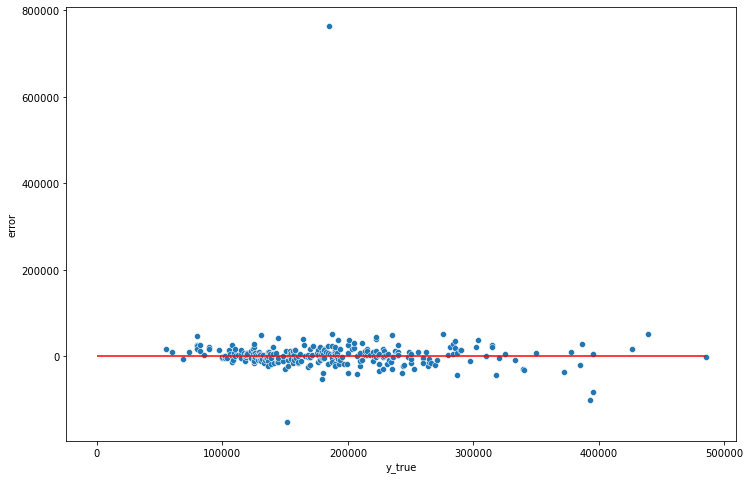

In [59]:
# Plot the training data predictions
test_predictions = np.exp(trained_lr_pipeline.predict(X_test))
r2 = r2_score(y_test, test_predictions)
print('r2 score: ', r2)
plot_predictions(y_test, test_predictions)

In [68]:
# store the trained pipeline
import pickle
pickle.dump(trained_lr_pipeline, 
            open(file='models/trained_pipe_linear_reg.sav', 
                 mode='wb'))

In [86]:
# load the trained pipeline and try it out
loaded_model = pickle.load(open('models/trained_pipe_linear_reg.sav', 'rb'))
 
# prediction
loaded_model.predict(pd.DataFrame(X_test.iloc[1]).T)

array([11.76960754])

### KNN pipeline

1.0

        RMSLE: 0.0
        MSE: 0.0
        RMSE: 0.0
        MAE: 0.0
        
755000.0 34900.0


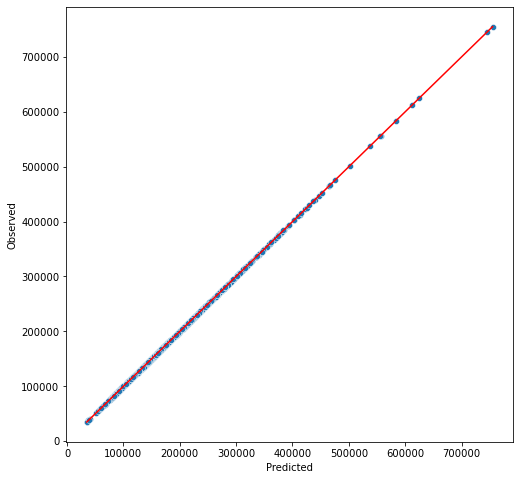

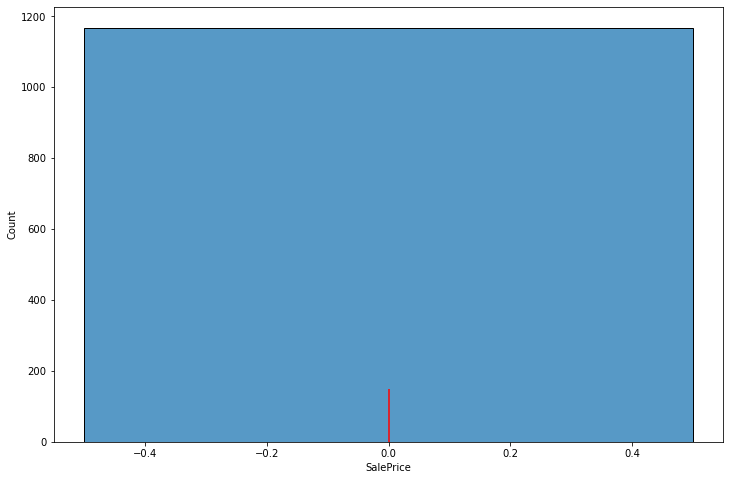

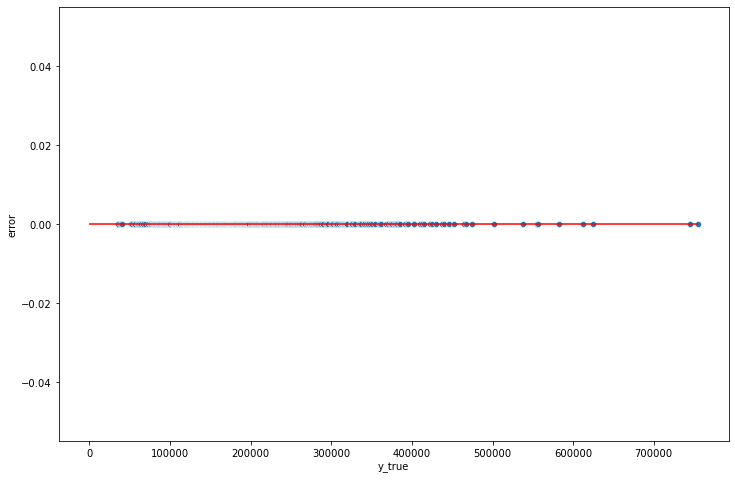

In [54]:
# pipeline
pipe = make_pipeline(
        full_processor,
        KNeighborsRegressor())
 
# parameter grid for pipeline
pipe_params = {
    'kneighborsregressor__n_neighbors': list(range(1, 20)),
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__p': [1, 2],
    'kneighborsregressor__algorithm': ['ball_tree', 'kd_tree', 'brute']}
 
# grid search
from sklearn.model_selection import GridSearchCV
trained_knn_pipe = GridSearchCV(pipe,
                            pipe_params, 
                            cv = 5)
trained_knn_pipe.fit(X_train, y_train)
 
# test accuracy on the test set
y_pred = trained_knn_pipe.predict(X_train)
 
r2 = r2_score(y_train, y_pred)
print(r2)
plot_predictions(y_train, y_pred)

0.7092206753823637

        RMSLE: 0.19285660598720292
        MSE: 1530154828.009149
        RMSE: 39117.19350885425
        MAE: 25949.954844362117
        
483625.6980613122 78525.20441011203


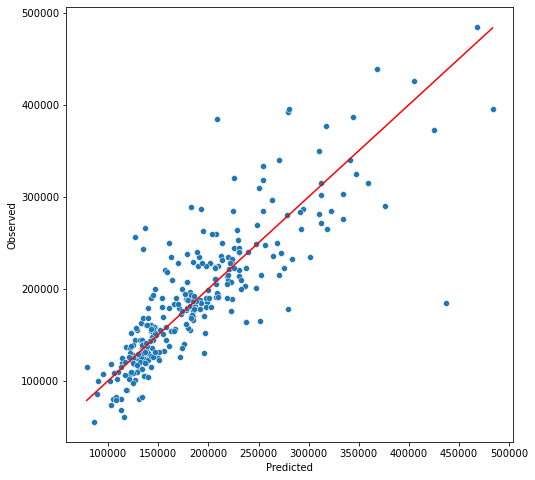

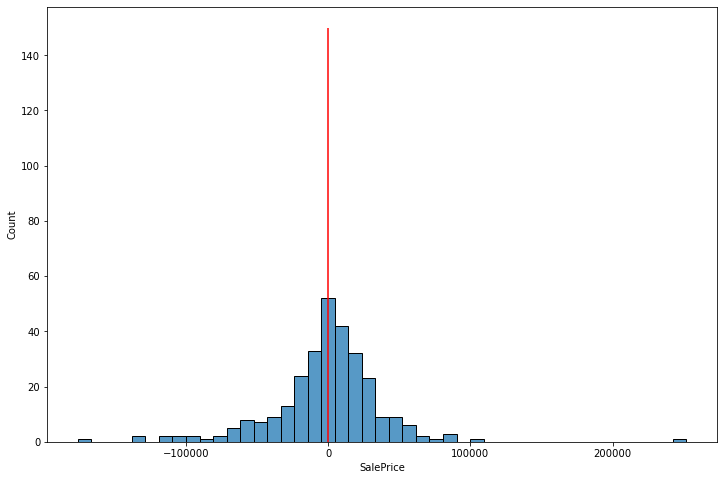

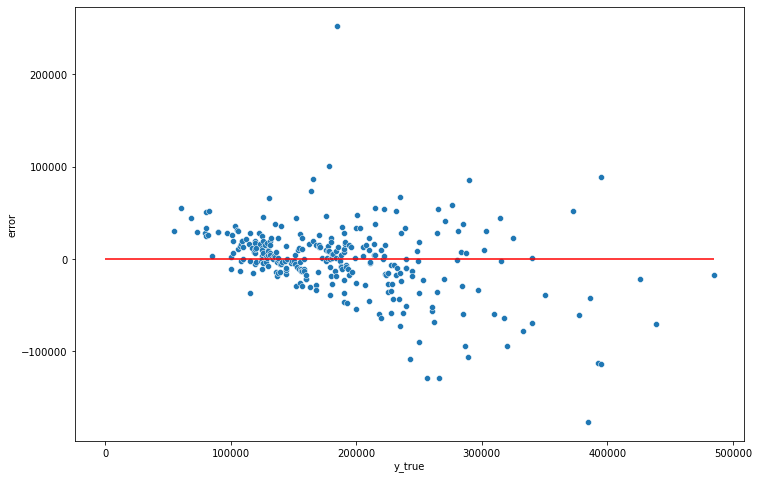

In [57]:
# test accuracy on the test set
y_pred = trained_knn_pipe.predict(X_test)
 
r2 = r2_score(y_test, y_pred)
print(r2)
plot_predictions(y_test, y_pred)

### Test knn on few features

In [74]:
# reading
import pandas as pd
housing = pd.read_csv("../data/Housing_data/housing-deployment-reg.csv")
 
# train test split
from sklearn.model_selection import train_test_split
X = housing.drop(columns="SalePrice")
y = housing["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=8)

pipe = make_pipeline(
        SimpleImputer(strategy='median'),
        StandardScaler(),
        KNeighborsRegressor())
 
# parameter grid for pipeline
pipe_params = {
    'simpleimputer__strategy':['median', 'mean'],
    'standardscaler__with_mean':[True, False],
    'kneighborsregressor__n_neighbors': list(range(1, 20)),
    'kneighborsregressor__weights': ['uniform', 'distance'],
    'kneighborsregressor__p': [1, 2],
    'kneighborsregressor__algorithm': ['ball_tree', 'kd_tree', 'brute']}
 
# grid search
from sklearn.model_selection import GridSearchCV
trained_pipe = GridSearchCV(pipe,
                            pipe_params, 
                            cv = 5)
trained_pipe.fit(X_train, y_train)
 
# test accuracy on the test set 
y_pred = trained_pipe.predict(X_test)
 
r2 = r2_score(y_test, y_pred)
print(r2)


0.7222877652002777


In [76]:
# store the trained pipeline
import pickle
pickle.dump(trained_pipe, 
            open(file='models/trained_pipe_knn.sav', 
                 mode='wb'))

In [77]:
# load model
import pickle
loaded_model = pickle.load(open('models/trained_pipe_knn.sav', 'rb'))
 
# new house with fake data
import pandas as pd
new_house = pd.DataFrame({
    'LotArea':[9000],
    'TotalBsmtSF':[1000], 
    'BedroomAbvGr':[5], 
    'GarageCars':[4]
})
 
# prediction
loaded_model.predict(new_house)

array([211511.97887967])

In [78]:
new_house

,LotArea,TotalBsmtSF,BedroomAbvGr,GarageCars
0,9000,1000,5,4
